# Recommendation Systems

This notebook uses an e-commerce example to build a recommendation system to recommend products to customers. 

## Libraries

In [145]:
!pip install numpy==1.21.5 pandas matplotlib sklearn tensorflow fuzzywuzzy

In [146]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import sklearn as sk
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

In [147]:
print(np.__version__)

1.21.5


In [148]:
print(tf.__version__)

2.7.1


## Load and Explore Data

In [149]:
tlog = pd.read_csv(r"../data/sample_tlog.csv", index_col = 0)
product = pd.read_csv(r"../data/sample_product.csv", index_col = 0)
customer = pd.read_csv(r"../data/sample_customer.csv", index_col = 0).replace({"H": "high", "L": "low", "M": "medium"})

In [150]:
product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938 entries, 0 to 2937
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   upc_no                 2938 non-null   int64 
 1   upc_desc               2938 non-null   object
 2   category_no_level_1    2938 non-null   int64 
 3   category_desc_level_1  2938 non-null   object
 4   category_no_level_2    2938 non-null   int64 
 5   category_desc_level_2  2938 non-null   object
dtypes: int64(3), object(3)
memory usage: 160.7+ KB


In [151]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1243 non-null   int64  
 1   convenience_dim_seg    1243 non-null   object 
 2   quality_dim_seg        1243 non-null   object 
 3   health_dim_seg         1243 non-null   object 
 4   price_dim_seg          1243 non-null   object 
 5   convenience_dim_score  1243 non-null   float64
 6   quality_dim_score      1243 non-null   float64
 7   health_dim_score       1243 non-null   float64
 8   price_dim_score        1243 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 97.1+ KB


In [152]:
tlog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595306 entries, 0 to 595305
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   transaction_id       595306 non-null  object 
 1   customer_id          595306 non-null  int64  
 2   upc_no               595306 non-null  int64  
 3   category_no_level_1  595306 non-null  int64  
 4   trans_dt             595306 non-null  int64  
 5   week_no              595306 non-null  int64  
 6   store_id             595306 non-null  int64  
 7   region_cd            595306 non-null  int64  
 8   purchase_unit        595306 non-null  int64  
 9   sales_amt            595306 non-null  float64
 10  disc_amt             595306 non-null  float64
 11  purchase_price       595283 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 59.0+ MB


In [153]:
# encode customer_id and upc_no to start from 0
customer = customer.assign(customer_id_code = customer.customer_id.astype("category").cat.codes)
product = product.assign(upc_no_code = product.upc_no.astype("category").cat.codes)

tlog = tlog.merge(customer[["customer_id", "customer_id_code"]], on = "customer_id", how = "left")\
.merge(product[["upc_no", "upc_no_code"]], on = "upc_no", how = "left")

In [154]:
sales = tlog[["customer_id_code", "upc_no_code", "purchase_unit"]]\
.rename({"customer_id_code": "customer_id", "upc_no_code": "upc_no"}, axis = 1)\
.groupby(["customer_id", "upc_no"])\
.agg({"purchase_unit": "sum"}).reset_index()
sales.head()

,customer_id,upc_no,purchase_unit
0,0,363,1
1,0,1358,1
2,0,1361,2
3,0,1363,1
4,1,6,18


In [155]:
print("There are {:.0f} products, {:.0f} customers in the dataset.".format(
    len(tlog.upc_no.unique()),
    len(tlog.customer_id.unique())))

There are 2938 products, 1243 customers in the dataset.


### Customers

array([[<AxesSubplot:title={'center':'# of units purchased per customer'}>]],
      dtype=object)

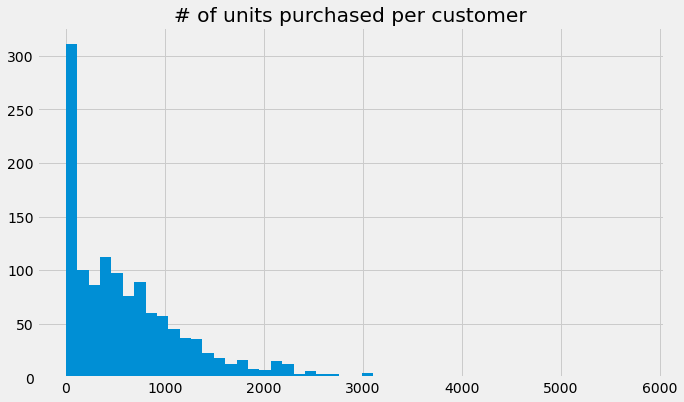

In [12]:
sales.groupby("customer_id")\
.agg(purchase_unit_sum = ("purchase_unit", "sum"))\
.reset_index()\
.drop("customer_id", axis = 1)\
.rename({"purchase_unit_sum": "# of units purchased per customer"}, axis = 1)\
.hist(figsize = (10, 6), bins = 50)

<AxesSubplot:title={'center':'Price Dimension'}>

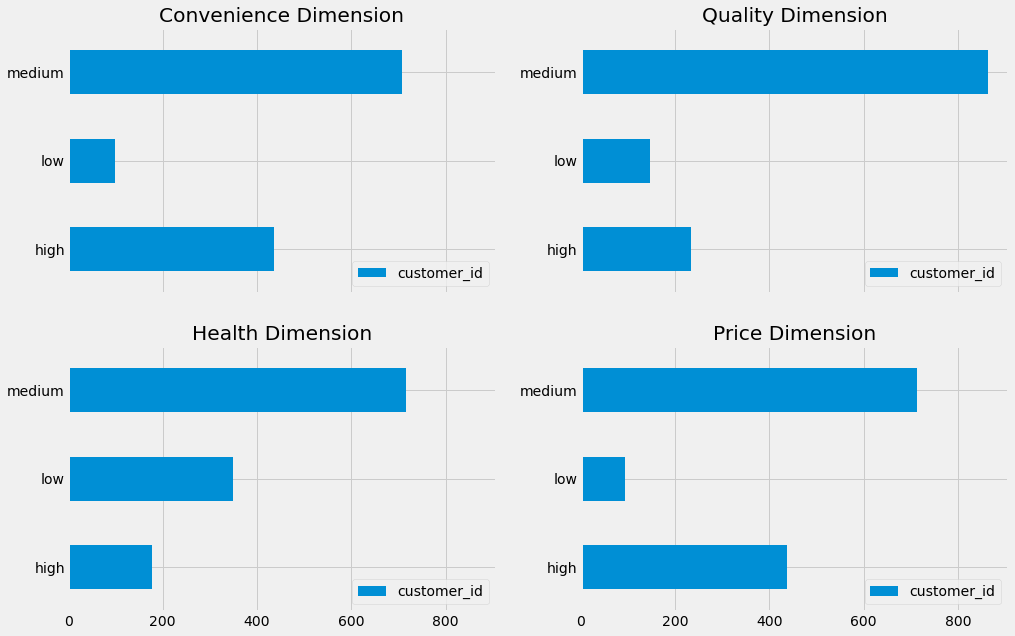

In [13]:
fig, ax = plt.subplots(2,2, sharex = True)
figsize = (15, 10)

customer.groupby(["convenience_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[0][0], title = "Convenience Dimension", xlabel = "")

customer.groupby(["quality_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[0][1], title = "Quality Dimension", xlabel = "")

customer.groupby(["health_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[1][0], title = "Health Dimension", xlabel = "")

customer.groupby(["price_dim_seg"])\
.agg({"customer_id": "count"})\
.plot.barh(figsize = figsize, ax = ax[1][1], title = "Price Dimension", xlabel = "")

### Products

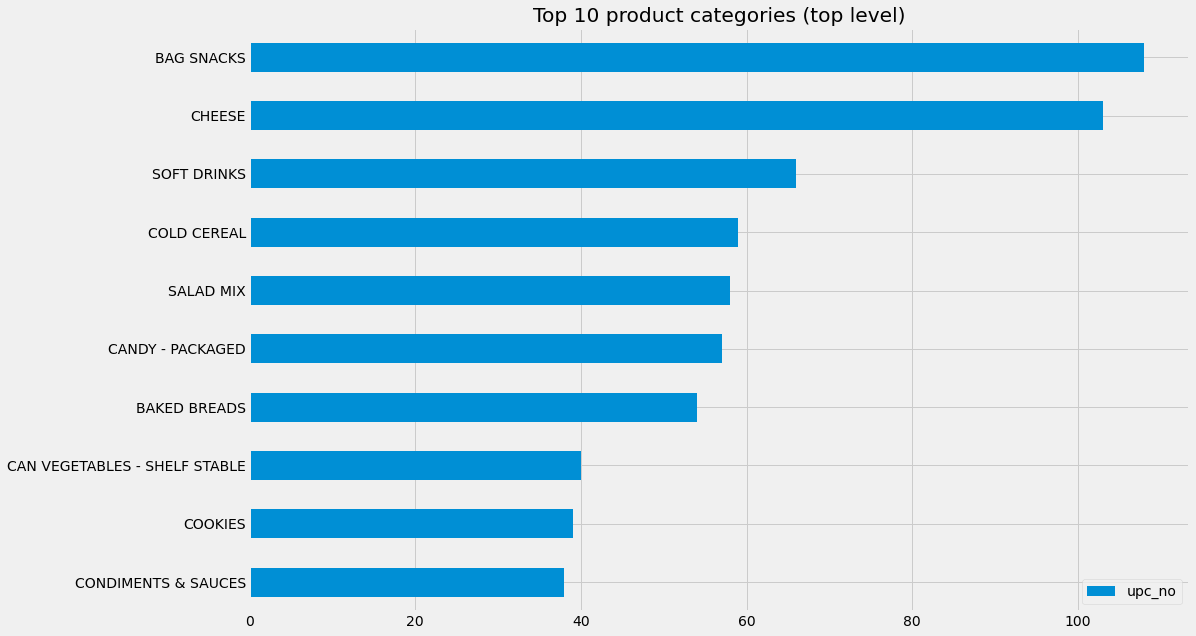

In [14]:
top = 10
product.groupby(["category_desc_level_2"])\
.agg({"upc_no": "count"})\
.reset_index()\
.sort_values(by = "upc_no", ascending = False)[:top]\
.plot.barh(x = "category_desc_level_2", y = "upc_no", figsize = figsize, title = "Top {:.0f} product categories (top level)".format(top), xlabel = "")
plt.gca().invert_yaxis()

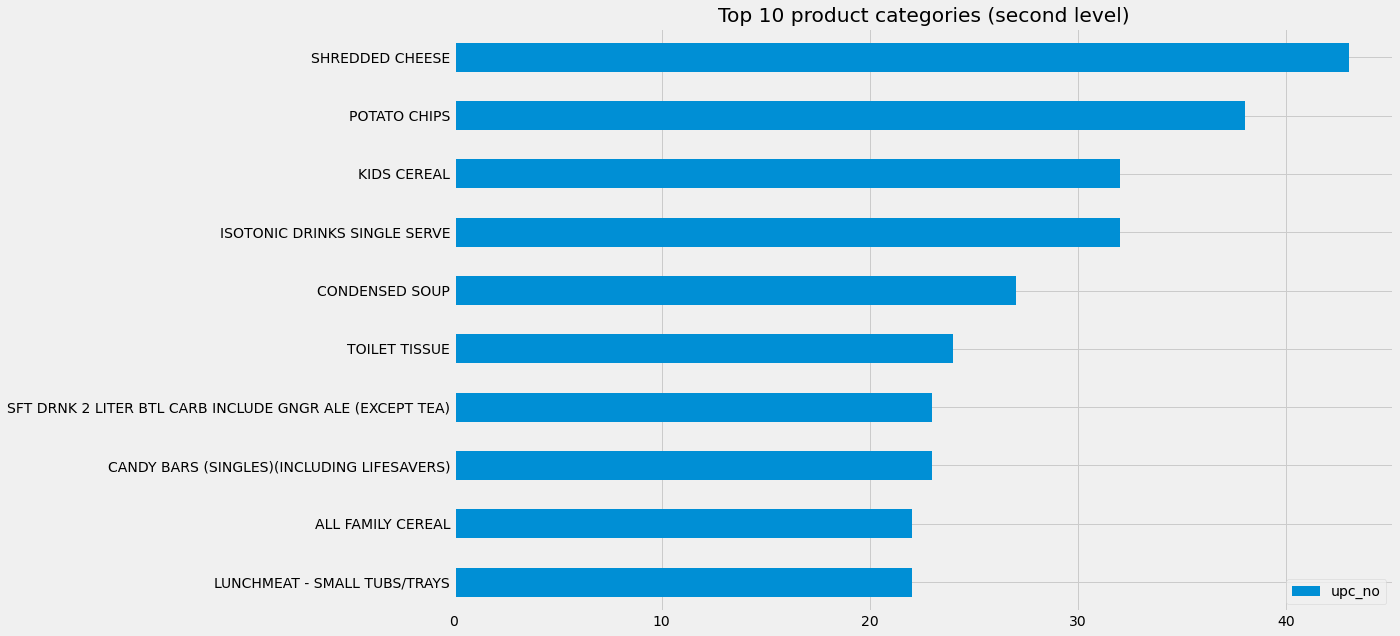

In [15]:
product.groupby(["category_desc_level_1"])\
.agg({"upc_no": "count"})\
.reset_index()\
.sort_values(by = "upc_no", ascending = False)[:top]\
.plot.barh(x = "category_desc_level_1", y = "upc_no", figsize = figsize, title = "Top {:.0f} product categories (second level)".format(top), xlabel = "")
plt.gca().invert_yaxis()

<AxesSubplot:title={'center':'# of units purchased for each product'}>

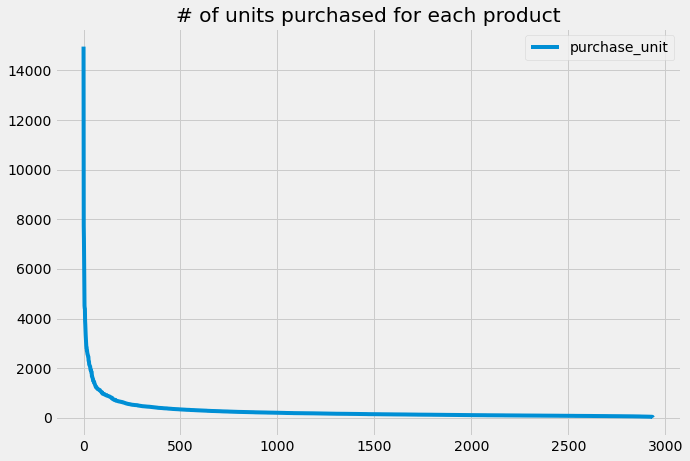

In [16]:
sales.groupby("upc_no").agg({"purchase_unit": "sum"})\
.sort_values("purchase_unit", ascending = False).reset_index(drop = True)\
.plot(figsize = (10,7), title = "# of units purchased for each product")

## Recommendation Algorithms

In [156]:
sales = sales.assign(purchase = lambda x: x["purchase_unit"] > 0)\
.replace({True: 1, False: 0})
sales.head(2)

,customer_id,upc_no,purchase_unit,purchase
0,0,363,1,1
1,0,1358,1,1


### Matrix-Based Implementation with Tensorflow

- [reference](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=8k9CSOH5o4tX)

#### Sparse representation of transaction matrix in tensorflow and loss calculation

In `sales` we have:

customer\_id | upc\_no | purchase_unit
--:|--:|--:
0|1|	1
0|2|	1
0|3|	2
0|4|	1
1|5|	18

We can transform to a transaction matrix where each row is a customer and each column is a product:
$$
A =
\begin{bmatrix}
1 & 1 & 2 & 1 & 0 \\
0 & 0 & 0 & 0 & 18
\end{bmatrix}
$$

And the Sparse Representation of the Transaction Matrix is:
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [0, 2], [0, 3], [1,4]],
  values=[1, 1, 2, 1, 18],
  dense_shape=[2, 5])
```

In [24]:
def build_transaction_sparse_tensor(df):
    indices = df[["customer_id", "upc_no"]].values
    values = df["purchase"].values
    return tf.SparseTensor(
        indices = indices,
        values = values,
        dense_shape = [len(customer), len(product)]
    )

Now imagine we have two embedding matrices, $U$ for customer embedding, and $V$ for product embedding, and want to be able to represent the transaction matrix $A$ by their product. How we achieve that is by minimizing the loss function calculating the difference between the transaction matrix $A$ and the dot product of two embedding matrices:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$

In [25]:
# computing full matrix UV, need to be updated if number of customers too large
def sparse_mean_squared_error(sparse_transactions, customer_embeddings, product_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(customer_embeddings, product_embeddings, transpose_b = True), 
        sparse_transactions.indices    
    )
    loss = tf.losses.mean_squared_error(sparse_transactions.values, predictions)
    return loss

In [40]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics = None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None
        
    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations = 100, learning_rate = 1.0, plot_result = True,
             optimizer = tf.train.GradientDescentOptimizer):
        
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer()
            )
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()
                    
            with self._session.as_default():
                local_init_op.run()
                iterations = []
                metrics = self._metrics or ({},)
                metrics_vals = [collections.defaultdict(dict) for _ in self._metrics]
                
            
                for i in range(num_iterations + 1):
                    _, results = self._session.run((train_op, metrics))
                    if (i % 10 == 0) or i == num_iterations:
                        print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]), 
                        end = "")

                        iterations.append(i)

                        for metric_val, result in zip(metrics_vals, results):
                            for k, v in result.items():
                                if k not in metric_val:
                                    metric_val[k] = [v]
                                else:
                                    metric_val[k].append(v)

                for k, v in self._embedding_vars.items():
                    self._embeddings[k] = v.eval()

                if plot_result:
                    num_subplots = len(metrics) + 1
                    fig = plt.figure()
                    fig.set_size_inches(num_subplots * 10, 8)
                    for i, metric_vals in enumerate(metrics_vals):
                        ax = fig.add_subplot(1, num_subplots, i + 1)
                        for k, v in metric_vals.items():
                            ax.plot(iterations, v, label = k)
                        ax.set_xlim([1, num_iterations])
                        ax.legend()

            return results

In [41]:
def build_model(mat, embedding_dim = 3, init_stddev = 1.):
    train, test = sk.model_selection.train_test_split(sales, test_size=0.2)
    A_train = build_transaction_sparse_tensor(train)
    A_test = build_transaction_sparse_tensor(test)
    U = tf.Variable(
        tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev = init_stddev
        )
    )
    V = tf.Variable(
        tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev = init_stddev
        )
    )
    train_loss = sparse_mean_squared_error(A_train, U, V)
    test_loss = sparse_mean_squared_error(A_test, U, V)
    metrics = {
        "train_error": train_loss,
        "test_error": test_loss
    }
    embeddings = {
        "customer_id": U,
        "upc_no": V
    }
    return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.016435, test_error=0.052462

[{'train_error': 0.016434701, 'test_error': 0.05246189}]

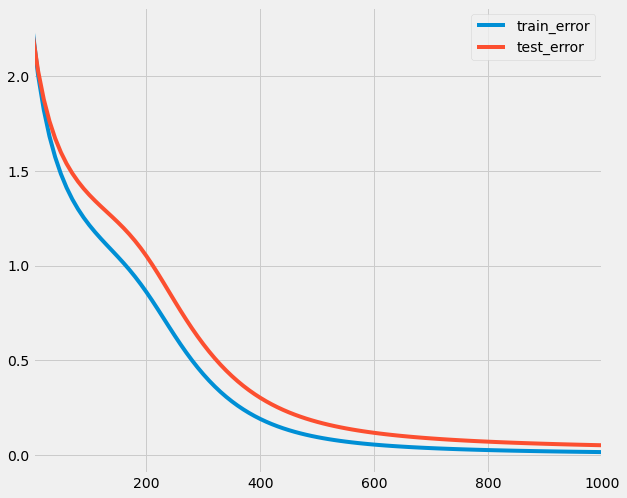

In [42]:
model = build_model(sales, embedding_dim = 20, init_stddev = 0.5)
model.train(num_iterations = 1000, learning_rate = 10.)

#### Compute score of each product $V_j$

In [48]:
DOT = 'dot'
COSINE = 'cosine'

def compute_score(query_embedding, item_embeddings, measure = COSINE):
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        u = u / np.linalg.norm(u)
        V = V / np.linalg.norm(V, axis = 1, keepdims = True)
    return u.dot(V.T)

In [103]:
# for each customer, recommend products
def customer_recommendation(model, customer_id, measure = COSINE, k = 10, exclude_bought = False):
    scores = compute_score(
        model.embeddings["customer_id"][customer_id], 
        model.embeddings["upc_no"], 
        measure
    )
    score_key = measure + " score"
    df = pd.DataFrame({
        score_key: list(scores),
        "product id": product["upc_no_code"],
        "product name": product["upc_desc"],
        "category": product["category_desc_level_1"],
        "subcategory": product["category_desc_level_2"]
    })
    if exclude_bought:
        bought_items = sales.query("customer_id == @customer_id")["upc_no"].unique()
        df = df[df["product id"].apply(lambda x: x not in bought_items)]
    display.display(df.sort_values([score_key], ascending = False).head(k))

In [104]:
customer_recommendation(model, 8)

,cosine score,product id,product name,category,subcategory
46,0.866379,1151,KRO MPL BRKFS SSG PATTIES,BKFST SAUSAGE - FRESH PATTIES,BREAKFAST SAUSAGE
421,0.846903,487,KRO CARBMSTR BLCKBRY BLD,YOGURT/SS LIGHT,YOGURT
1719,0.836362,2275,CAMP FRENCH ONION SOUP,CONDENSED SOUP,CANNED SOUPS
399,0.814979,2661,KTTL SEA SALT&VINGR CHIPS,POTATO CHIPS,NF SNACK
22,0.812196,1530,HNTS TOMATO SAUCE,TOMATO SAUCE,TOMATO PRODUCTS-SHELF STABLE
2674,0.803091,435,KRO FC ORANGE JCE W/CALC,DAIRY CASE 100% PURE JUICE - OJ,REFRGRATD JUICES/DRINKS
104,0.781235,666,PRSL POTATOES FNGRLNG BAG,POTATOES GOURMET,POTATOES
1090,0.770033,1280,BEYE SWEET KERNEL CORN,FZ BAG VEGETABLES - PLAIN,FROZEN VEGETABLE & VEG DISH
44,0.768330,2123,HLSR ULTRA THIN HONEY HAM,LUNCHMEAT - SMALL TUBS/TRAYS,LUNCHMEAT
60,0.767923,2251,DMNO LIGHT BROWN SUGAR,SUGAR,SUGARS & SWEETENERS


In [123]:
# for each product find similar products
def product_neighbors(model, desc, measure = COSINE, k = 10):
    ids = product[product["upc_desc"].str.contains(desc)].index.values
    descs = product.iloc[ids]["upc_desc"].values
    
    if len(descs) == 0:
        raise ValueError("Found no products for %s" % desc)
    print("Nearest neighbors of : %s." % descs[0])
    
    if len(descs) > 1:
        print("Found more than 1 matching product. Other candidates: {}".format(", ".join(descs[1:])))

    prod_id = ids[0]
    scores = compute_score(
        model.embeddings["upc_no"][prod_id], model.embeddings["upc_no"], measure
    )
    score_key = measure + " score"
    df = pd.DataFrame({
        score_key : list(scores),
        "product name": product["upc_desc"],
        "category": product["category_desc_level_1"],
        "subcategory": product["category_desc_level_2"]
    })
    display.display(df.sort_values([score_key], ascending = False).head(k))

In [168]:
p = "coffee"
product_neighbors(model, p.upper())

Nearest neighbors of : HOST CINN COFFEE CAKE 8CT.
Found more than 1 matching product. Other candidates: MXHS ORIGINAL COFFEE


,cosine score,product name,category,subcategory
756,1.000000,HOST CINN COFFEE CAKE 8CT,SNACK CAKE - MULTI PACK,BAKED SWEET GOODS
1186,0.691341,KRO RB 3 PPR & ONION BLND,FZ BAG VEGETABLES - VALUE ADDED,FROZEN VEGETABLE & VEG DISH
818,0.665711,DIAL SPRNG WTR LIQ HND SP,LIQUID SOAP,SOAP - LIQUID & BAR
683,0.639260,CHEEZIT ORIG CRCKR FMY SZ,CHEESE CRACKERS,CRACKERS & MISC BAKED FOOD
1378,0.633162,KAHN DELUXE CLUB BOLOGNA,BOLOGNA/LOAVES/FRANKS/BACON,DELI MEAT: BULK
1082,0.624379,KRO VEGETABLE STIR FRY,FZ BAG VEGETABLES - PLAIN,FROZEN VEGETABLE & VEG DISH
1452,0.621677,HUGG ONE & DONE DSNY WPES,SOFT PACKS,BABY WIPES
2727,0.616563,KRO NAT CAULIFLOWER,FRZN STEAMABLE VEGETABLES,FROZEN VEGETABLE & VEG DISH
960,0.613622,FRITOS MILD CHEDDAR DIP,SALSA & DIPS,BAG SNACKS
2494,0.612500,KBLR TWNHS SEA SALT PITA,BUTTER SPRAY CRACKER,CRACKERS & MISC BAKED FOOD


In [169]:
product_neighbors(model, p.upper(), measure = DOT)

Nearest neighbors of : HOST CINN COFFEE CAKE 8CT.
Found more than 1 matching product. Other candidates: MXHS ORIGINAL COFFEE


,dot score,product name,category,subcategory
756,4.806355,HOST CINN COFFEE CAKE 8CT,SNACK CAKE - MULTI PACK,BAKED SWEET GOODS
818,3.546902,DIAL SPRNG WTR LIQ HND SP,LIQUID SOAP,SOAP - LIQUID & BAR
2615,3.541006,KRO COLBY CHEESE BAR,NATURAL CHEESE CHUNKS,CHEESE
2494,3.133872,KBLR TWNHS SEA SALT PITA,BUTTER SPRAY CRACKER,CRACKERS & MISC BAKED FOOD
1934,3.109420,KRO ONIONS SWEET,ONIONS SWEET (BULK&BAG),ONIONS
2345,3.090833,HNTS MNWCH THICK & CHUNKY,SANDWICH SAUCE (MANWICH),MEAT - SHELF STABLE
2862,2.921450,SAS PAPRIKA,TRADITIONAL SPICES,SPICES & EXTRACTS
266,2.862960,BUSH BLACK BEANS,VARIETY BEANS - KIDNEY/PINTO/ETC,CAN BEANS
1840,2.820492,SWTBR BBQ SAUCE,BBQ SAUCE,CONDIMENTS & SAUCES
1082,2.802999,KRO VEGETABLE STIR FRY,FZ BAG VEGETABLES - PLAIN,FROZEN VEGETABLE & VEG DISH


#### Visualize product embeddings

In [315]:
from sklearn.manifold import TSNE

def tsne_product_embedding(model):
    tsne = TSNE(
        n_components = 2,
        perplexity = 40, 
        metric = "cosine",
        early_exaggeration = 10,
        init = "pca",
        verbose = True, 
        n_iter = 400
    )
    V_proj = tsne.fit_transform(model.embeddings["upc_no"])
    product.loc[:, "x"] = V_proj[:, 0]
    product.loc[:, "y"] = V_proj[:, 1]
    return visualize_product_embedding(product, "x", "y")

def visualize_product_embedding(ax, data, x, y, category, color_map):
    return ax.scatter(data[x], data[y], c = data[category].map(color_map))

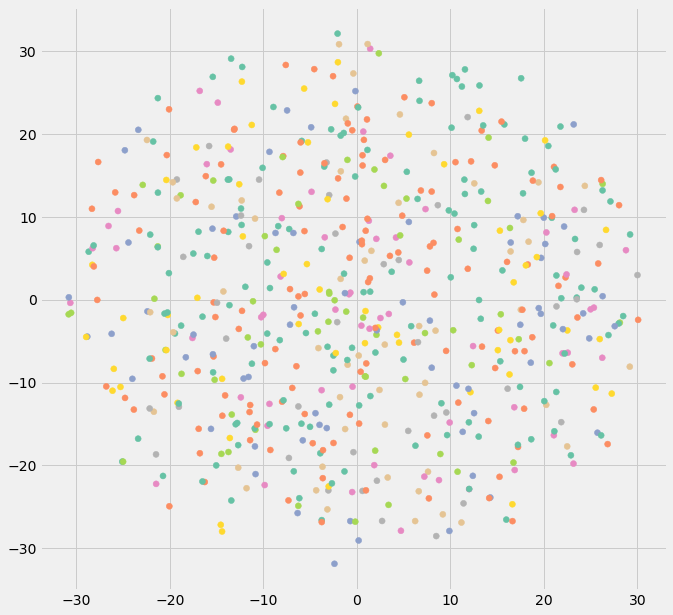

In [316]:
import seaborn as sns
top_n = 10
top_categories = product.groupby("category_desc_level_2").count().sort_values("upc_no", ascending = False)[:top_n].index
top_cat_product = product[product.category_desc_level_2.apply(lambda x: x in top_categories)]
color_map = dict(zip(top_categories, sns.color_palette("Set2", top_n)))

fig, ax = plt.subplots(figsize = (10,10))
scatter = visualize_product_embedding(ax, top_cat_product, "x", "y", "category_desc_level_2", color_map)
scatter